In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import joblib
import shutil

In [3]:
os.chdir("..")
sys.path.append("data")
sys.path.append("src")
# sys.path.append("scripts")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
!mkdir -p data/METR-LA

In [5]:
!python -m scripts.generate_training_data --output_dir=data/METR-LA --traffic_df_filename=data/metr-la.h5

Generating training data
x shape:  (34249, 12, 207, 2) , y shape:  (34249, 12, 207, 2)
train x:  (23974, 12, 207, 2) y: (23974, 12, 207, 2)
val x:  (3425, 12, 207, 2) y: (3425, 12, 207, 2)
test x:  (6850, 12, 207, 2) y: (6850, 12, 207, 2)


In [6]:
# !python -m scripts.generate_training_data --output_dir=data/PEMS-BAY --traffic_df_filename=data/pems-bay.h5

In [7]:
from data_pipeline import load_metr_la_data, convert_speed_to_congestion_label
from evaluation import plot_loss_accuracy

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [9]:
# Load preprocessed METR-LA data
x_train, y_train_speed = load_metr_la_data("train")
x_val, y_val_speed = load_metr_la_data("val")

# Convert speed targets to congestion labels (0=high, 1=medium, 2=low)
y_train_labels = convert_speed_to_congestion_label(y_train_speed)
y_val_labels = convert_speed_to_congestion_label(y_val_speed)

# Normalize input data (optional but recommended)
x_train = x_train / 100.0
x_val = x_val / 100.0

In [10]:
print(y_train_speed.shape, y_train_labels.shape)

(23974, 12, 207, 2) (23974,)


In [11]:
# Build classifier
model = Sequential([
    Flatten(input_shape=x_train.shape[1:]),  # (12, 207)
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # low, medium, high
])

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(x_train, y_train_labels, validation_data=(x_val, y_val_labels), epochs=10, batch_size=64)

Epoch 1/10
375/375 [==============================] - 1s 4ms/step - loss: 0.4673 - accuracy: 0.7785 - val_loss: 0.3771 - val_accuracy: 0.8450
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3493 - accuracy: 0.8435 - val_loss: 0.2992 - val_accuracy: 0.8861
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3623 - accuracy: 0.8341 - val_loss: 0.3288 - val_accuracy: 0.8774
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3406 - accuracy: 0.8439 - val_loss: 0.3338 - val_accuracy: 0.9004
Epoch 5/10
375/375 [==============================] - 1s 4ms/step - loss: 0.3391 - accuracy: 0.8564 - val_loss: 0.3585 - val_accuracy: 0.8768
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3073 - accuracy: 0.8745 - val_loss: 0.3304 - val_accuracy: 0.8818
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.2906 - accuracy: 0.8812 - val_loss: 0.3270 - val_accuracy: 0.8599
Epoch 

In [14]:
model.save("models/traffic_congestion_classifier.h5")


/Users/anveshradharapu/Library/Caches/pypoetry/virtualenvs/mlengineerprep-fSSVlCLJ-py3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


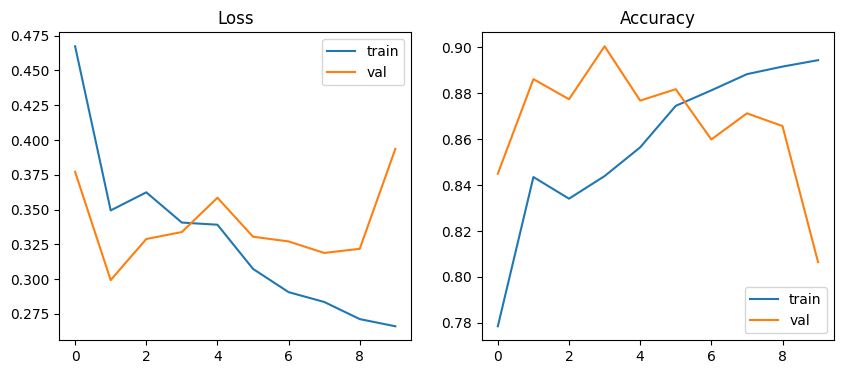

In [15]:
plot_loss_accuracy(model.history)

In [16]:
# Predict probabilities
y_val_pred_probs = model.predict(x_val)

# Convert softmax outputs to class labels (0, 1, 2)
y_val_preds = np.argmax(y_val_pred_probs, axis=1)


108/108 [==============================] - 0s 707us/step


In [17]:
# Ensure true labels are 1D
print(y_val_labels.shape)  # should be (N,)

# Generate report
report = classification_report(
    y_val_labels,
    y_val_preds,
    labels=[0, 1, 2],  # Ensure all classes are accounted for
    target_names=["High", "Medium", "Low"]
)

print(report)
with open('outputs/classification_report.txt', 'w') as f:
    f.write(report)


(3425,)
              precision    recall  f1-score   support

        High       0.74      0.94      0.83      1695
      Medium       0.92      0.67      0.78      1730
         Low       0.00      0.00      0.00         0

    accuracy                           0.81      3425
   macro avg       0.55      0.54      0.54      3425
weighted avg       0.83      0.81      0.80      3425



/Users/anveshradharapu/Library/Caches/pypoetry/virtualenvs/mlengineerprep-fSSVlCLJ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/anveshradharapu/Library/Caches/pypoetry/virtualenvs/mlengineerprep-fSSVlCLJ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/anveshradharapu/Library/Caches/pypoetry/virtualenvs/mlengineerprep-fSSVlCLJ-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined a

In [18]:
joblib.dump(model, 'models/traffic_congestion_classifier_model.pkl')

['models/traffic_congestion_classifier_model.pkl']

In [19]:
shutil.rmtree("data/METR-LA")
# shutil.rmtree("data/PEMS-BAY")